## Классификация MNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [2]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

100%|██████████| 9.91M/9.91M [00:00<00:00, 101MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 14.4MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 60.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.61MB/s]


Text(0.5, 1.0, 'Image label: 6')

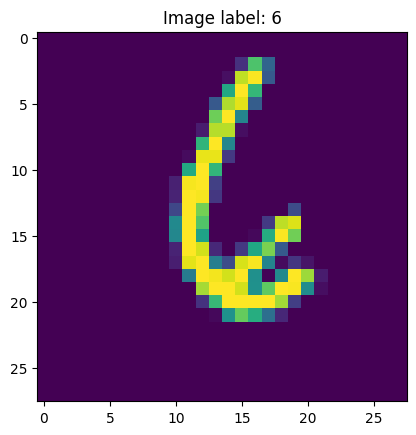

In [3]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [4]:
# Creating model instance
model = nn.Sequential(
  nn.Unflatten(1,(1,28,28)),
  nn.Conv2d(1,8,3,1,'same'),
  nn.BatchNorm2d(8),
  nn.MaxPool2d(2),
  nn.ReLU(),
  nn.Conv2d(8,16,3,1,'same'),
  nn.BatchNorm2d(16),
  nn.MaxPool2d(2),
  nn.ReLU(),
  nn.Flatten(),
  nn.Linear(16*7*7, 64),
  nn.ReLU(),
  nn.Linear(64, 10),
  nn.Softmax()
  ) # your code here

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.Dropout(.25),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.Softmax(),
)

Ниже доступны локальные тесты для проверки вашей модели:

In [5]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [7]:
# your code here
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(device)
model = model.to(device=device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(20):
    message = f"Epoch: {epoch:>3d}"
    train_correct = 0
    train_total = 0

    train_loss = 0

    test_correct = 0
    test_total = 0

    test_loss = 0

    model.train()
    for i, (inputs, labels) in enumerate(train_data_loader, 1):
      inputs = inputs.to(device)
      labels = labels.to(device)

      inputs = inputs.reshape(-1,28*28)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss = (train_loss * (i-1) + loss.item())/i

      train_correct += torch.sum(torch.argmax(outputs,dim=1) - labels == 0).item()
      train_total += len(labels)

    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_data_loader, 1):
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.reshape(-1,28*28)
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            test_correct += torch.sum(torch.argmax(outputs, dim=1) -labels == 0).item()
            test_total += len(labels)

            test_loss = (test_loss * (i-1) + loss.item()) / i
    message += f"\nAccuracy |train: {(train_correct / train_total):3>.3f}|test: {(test_correct / test_total):3>.3f}"
    message += f"\nLoss     |train: {train_loss:3>.3f}|test:{test_loss:3>.3f}"
    print(message)


cpu
Epoch:   0
Accuracy |train: 0.905|test: 0.925
Loss     |train: 1.567|test:1.543
Epoch:   1
Accuracy |train: 0.917|test: 0.931
Loss     |train: 1.553|test:1.536
Epoch:   2
Accuracy |train: 0.925|test: 0.937
Loss     |train: 1.543|test:1.530
Epoch:   3
Accuracy |train: 0.933|test: 0.942
Loss     |train: 1.535|test:1.524
Epoch:   4
Accuracy |train: 0.938|test: 0.945
Loss     |train: 1.529|test:1.520
Epoch:   5
Accuracy |train: 0.943|test: 0.950
Loss     |train: 1.523|test:1.516


KeyboardInterrupt: 

Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [8]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [9]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.95497


In [10]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [11]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9521


Проверка, что пороги пройдены:

In [12]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [23]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

AssertionError: Please, download `hw_mnist_data_dict.npy` and place it in the working directory

### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!